In [1]:
import numpy as np
import scipy as sp
from scipy import stats
import math as m
import pandas as pd
import matplotlib.pyplot as plt


Material: 1045CR
Diameter = 0.377 in
Gauge Length = 2.0 in
Torsional Rigidity = 23.979
Shear Modulus: G = 12091.09 ksi
Modulus of Rupture = 78.47 [ksi]


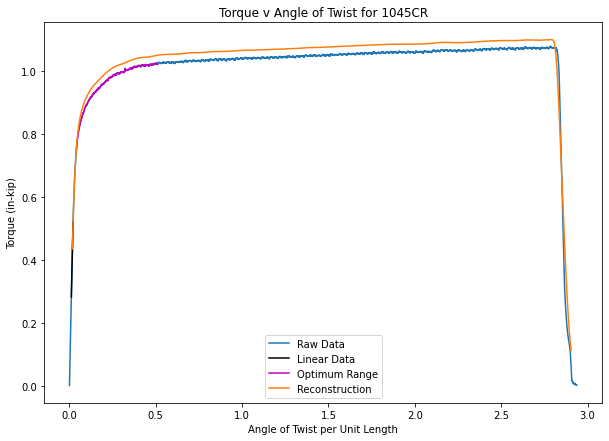

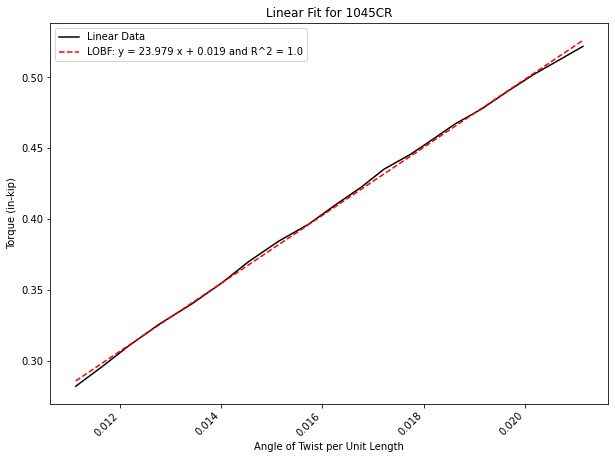

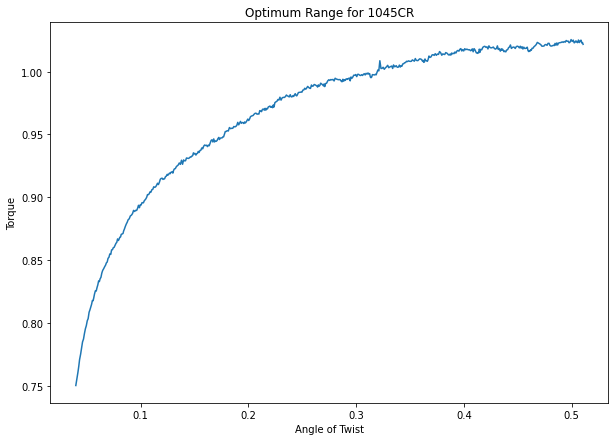

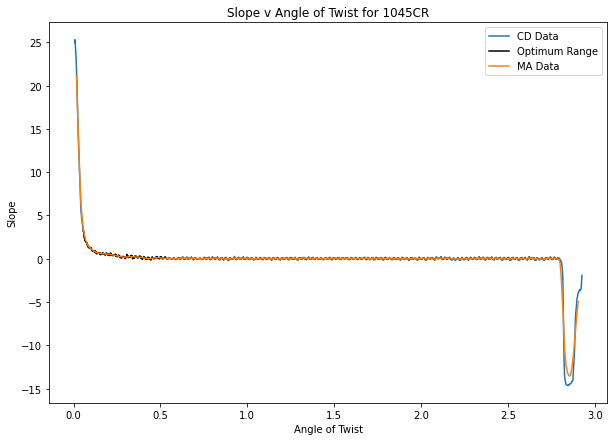

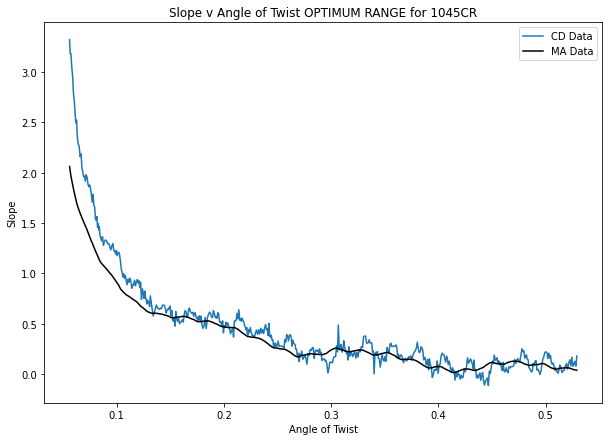

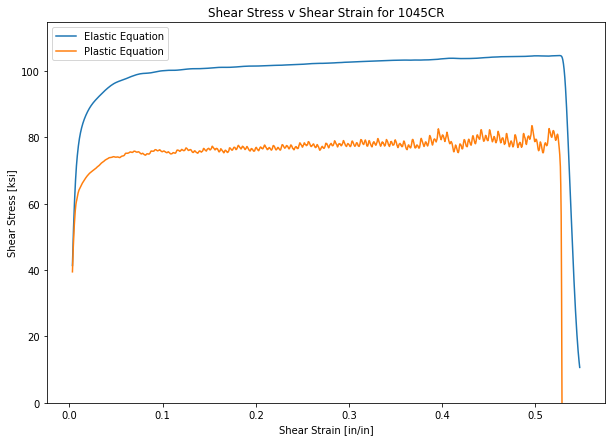

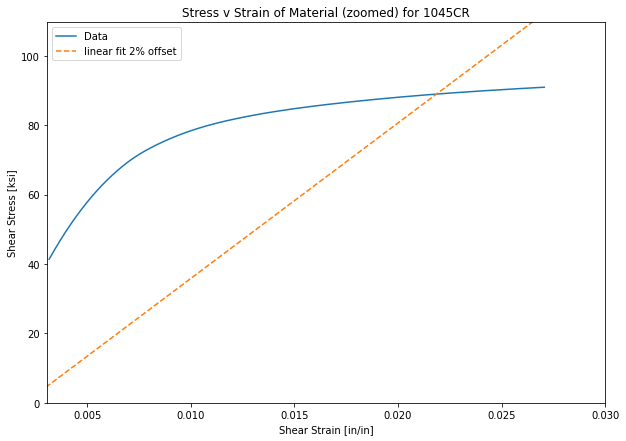


Material: 1018HR
Diameter = 0.376 in
Gauge Length = 2.0 in
Torsional Rigidity = 26.398
Shear Modulus: G = 13452.78 ksi
Modulus of Rupture = 56.78 [ksi]


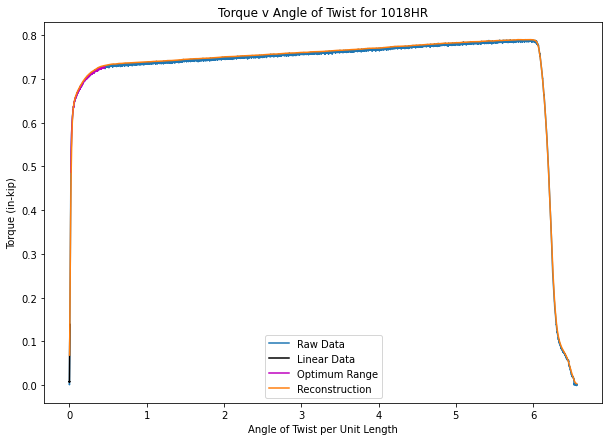

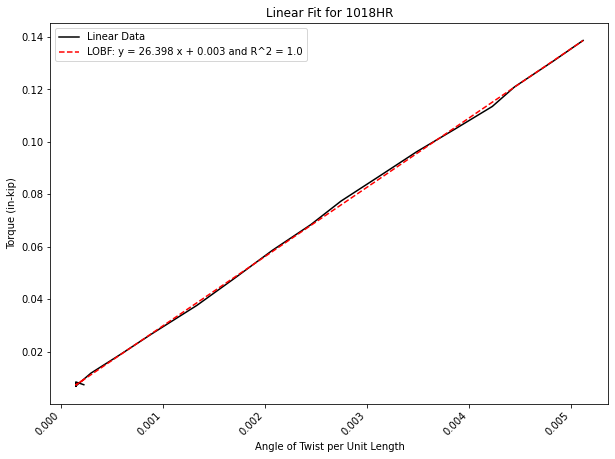

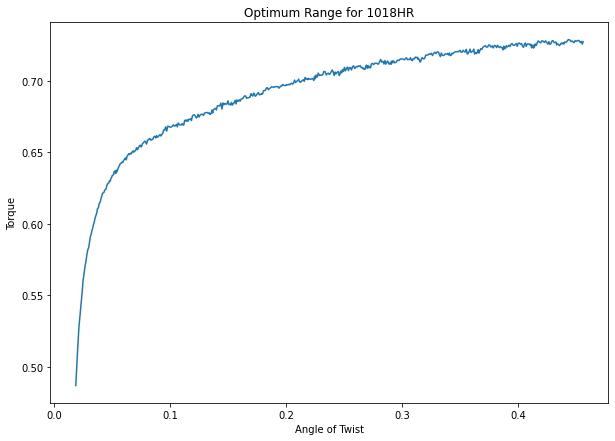

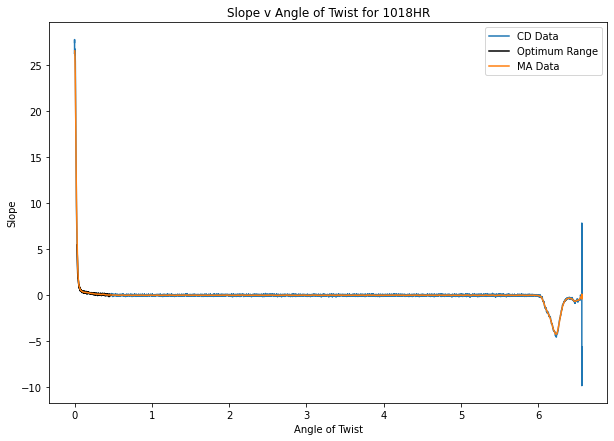

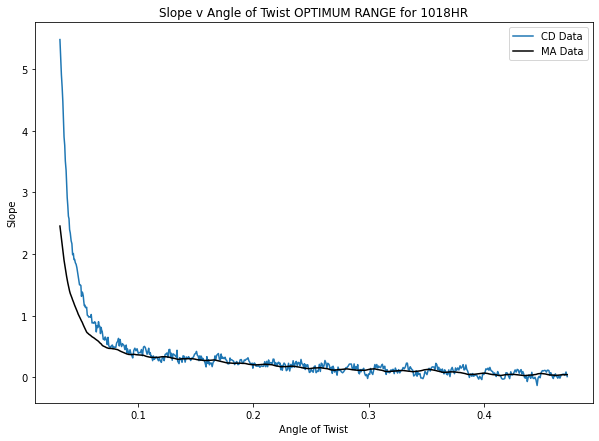

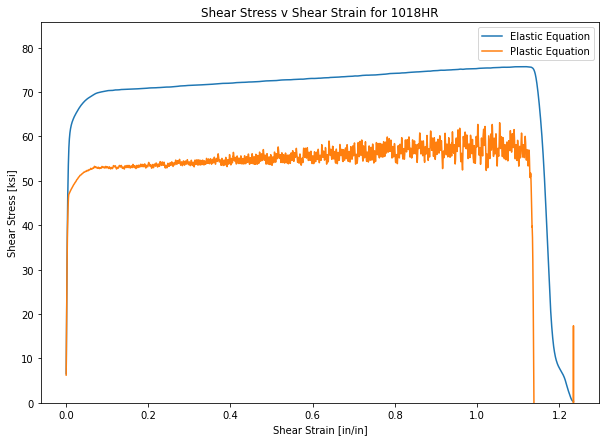

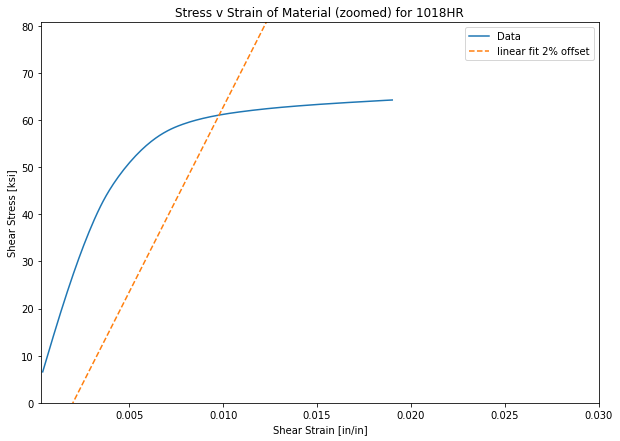


Material: Al6061
Diameter = 0.376 in
Gauge Length = 2.0 in
Torsional Rigidity = 8.426
Shear Modulus: G = 4294.3 ksi
Modulus of Rupture = 31.51 [ksi]


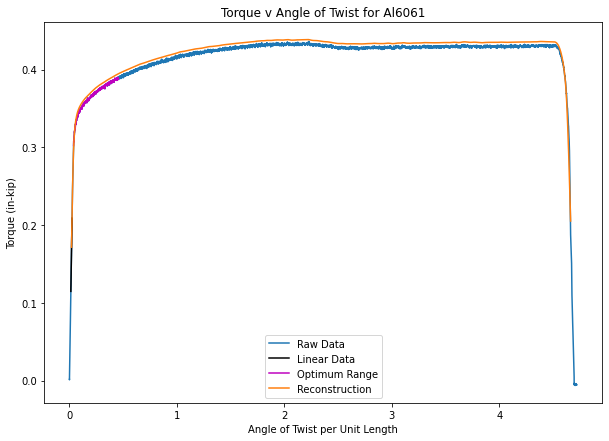

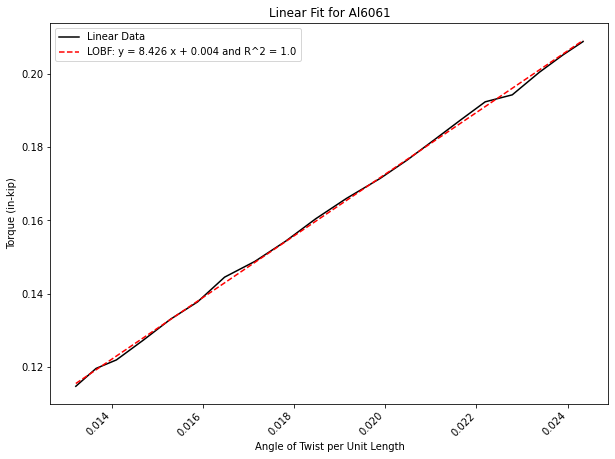

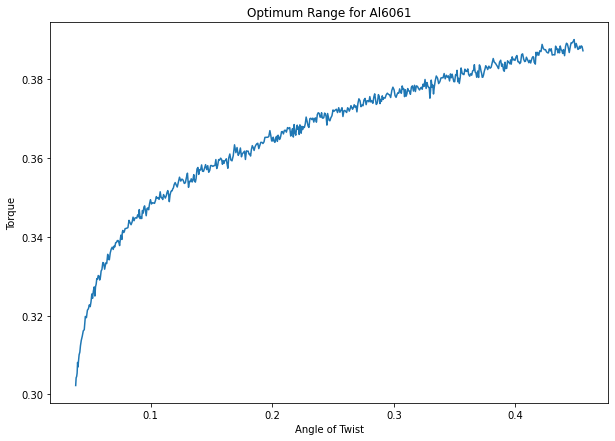

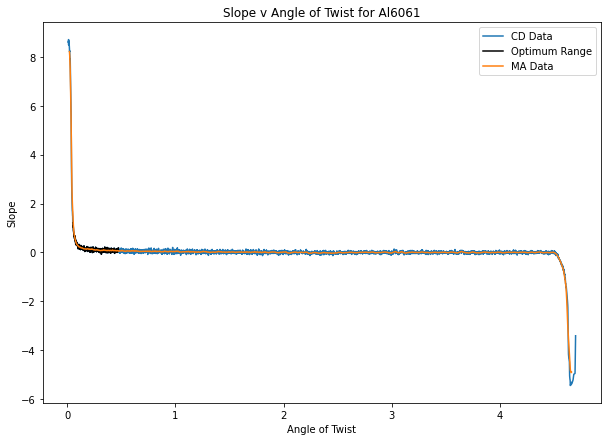

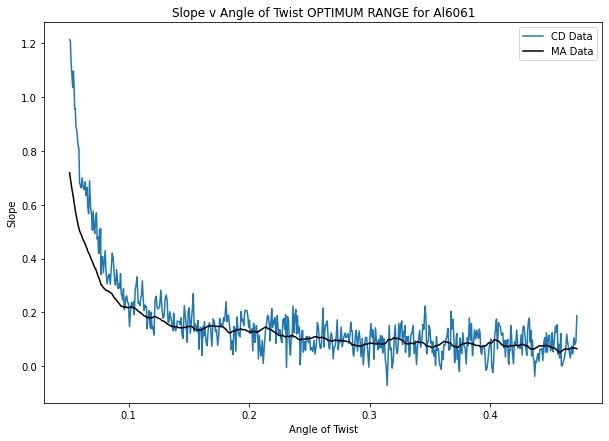

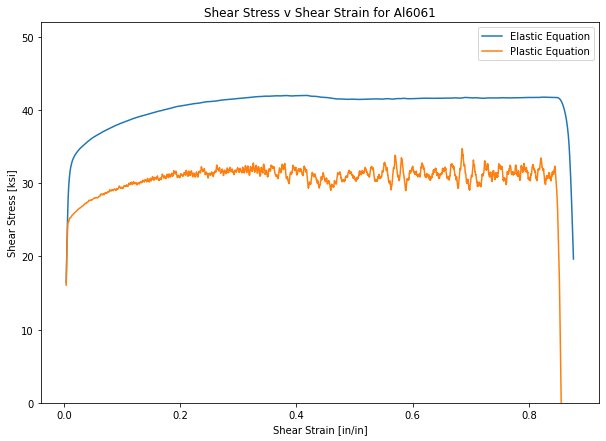

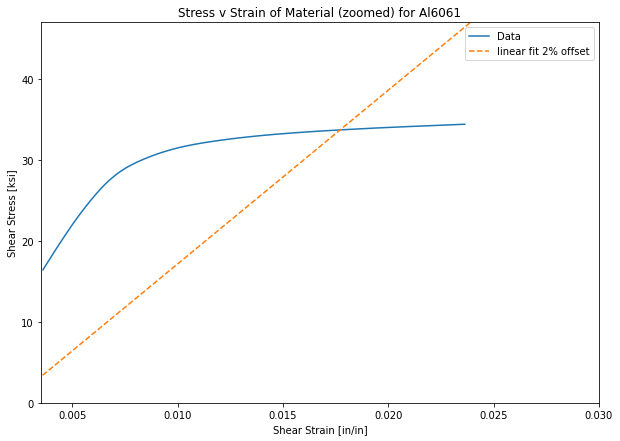


Material: Naval Brass
Diameter = 0.379 in
Gauge Length = 2.0 in
Torsional Rigidity = 12.693
Shear Modulus: G = 6266.46 ksi
Modulus of Rupture = 49.68 [ksi]


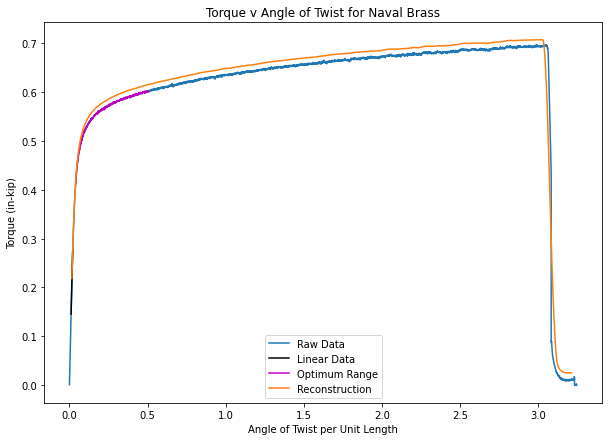

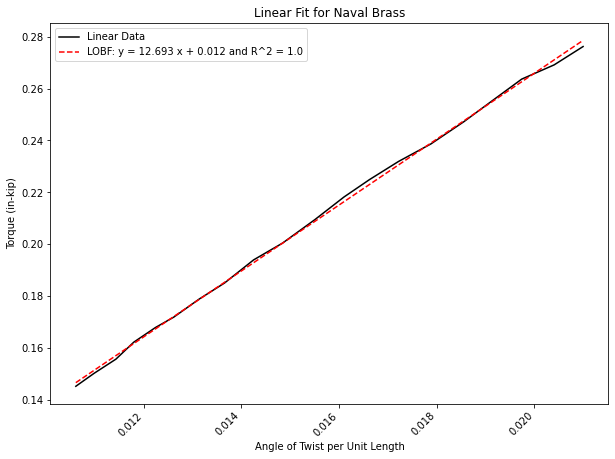

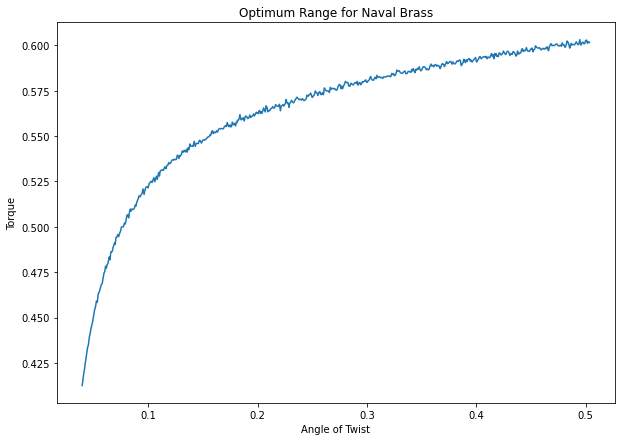

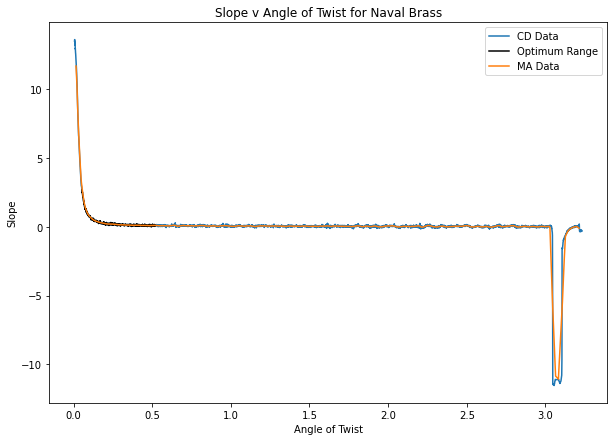

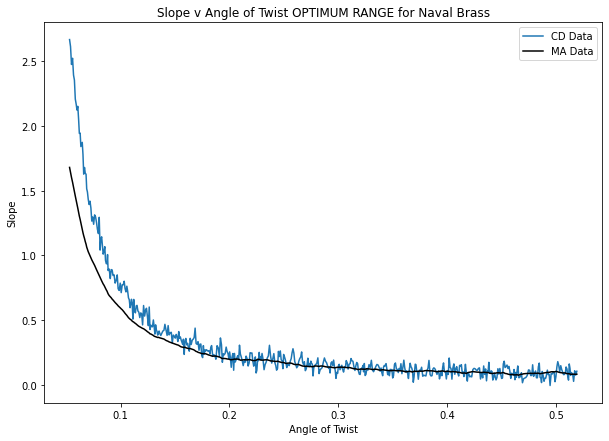

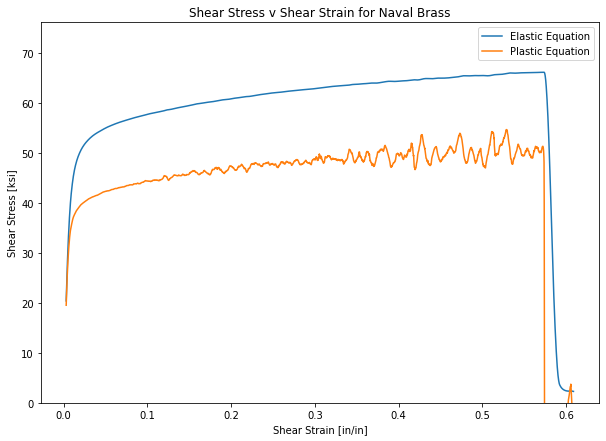

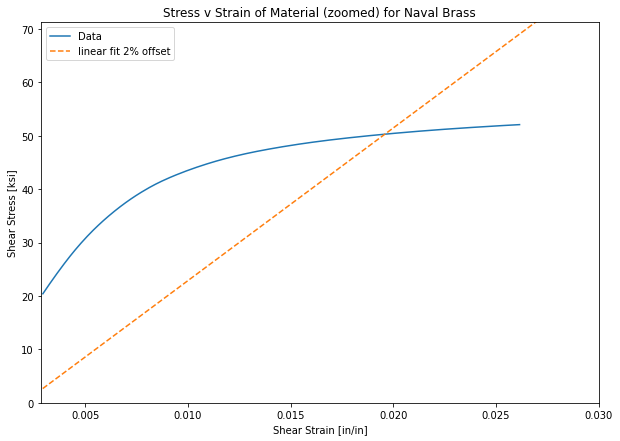

      Material             G    Rupture   Rigidity   Ductility
0       1045CR  12091.089236  78.469630  23.978981  104.626173
1       1018HR  13452.776684  56.784026  26.397525   75.712034
2       Al6061   4294.302766  31.511774   8.426436   42.015699
3  Naval Brass   6266.459052  49.675067  12.693428   66.233423


In [5]:
material = []
offset = []
proportional=[]
rupture = []
rigidity = []
ductility = []
shear_mod = []
final_data = pd.DataFrame()

data_file = pd.read_excel('Torsion_Test_BB.xlsx', sheet_name=None)

for name, sheet in data_file.items():
    sheet['sheet'] = name
    sheet = sheet.to_numpy()
    print(f'\nMaterial: {name}')

    #Data
    D = sheet[0,5] #in
    L = sheet[1,5] #in
    print(f'Diameter = {D} in')
    print(f'Gauge Length = {L} in')

    t = sheet[1:,0] #ms
    torque = sheet[1:,1].astype('float') #ft lb
    theta = sheet[1:,2].astype('float') #degree

    Torque = torque * 12 / 1000 #in kips
    phi = theta * (np.pi / 180) #radian
    phi_prime = phi / L 

    #Linear Fit
    linear_torque = Torque[30:50] # was 60
    linear_phi_prime = phi_prime[30:50] # was 60
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(
        linear_phi_prime, linear_torque)
    print(f'Torsional Rigidity = {round(slope, 3)}')

    #Shear Modulus
    J = np.pi / 2 *((D/2)**4)
    G = slope / J #Find UNITS
    print(f'Shear Modulus: G = {round(G, 2)} ksi')

    #Constants for Central Difference and Moving Average
    N = n = 20
    slopes = []

    #Central Difference 
    for i in range(np.size(phi_prime)):
      if i-N >= 0 and i+N<np.size(phi_prime):
        CD = (Torque[i+N] - Torque[i-N]) / (phi_prime[i+N] - phi_prime[i-N])
        slopes.append(CD)

    #Moving Average 
    MA = []
    for i in range(np.size(slopes)):
      if i-n >= 0 and i+n < np.size(slopes):
        upper = i-n
        lower = i+n+1
        val = np.mean(slopes[upper : lower])
        MA.append(val)
   

    #Optimum Window Raw
    upper = 650
    lower = 80
    opt_torque = Torque[lower:upper]
    opt_phi_prime = phi_prime[lower:upper]


    #Resize
    start = N
    end = len(phi_prime) - N
    phi_prime_resize = phi_prime[start:end]
    opt_phi_resize = phi_prime_resize[lower:upper]
    opt_slopes = slopes[lower:upper]

    start = n * 2
    end = len(phi_prime) - n * 2
    phi_prime_MA = phi_prime[start:end]

    opt_MA = MA[lower:upper]


    #Torque Reconstruction
    Recon_Torq = [Torque[n+N+1]]
    
    for i in range(1, np.size(MA)):
      TR = Recon_Torq[i-1]+MA[i]*(phi_prime_MA[i] - phi_prime_MA[i-1])
      Recon_Torq.append(TR)
    #print(Recon_Torq)

    #Shear Stuff 
    r = float(D/2)
    strain = (r)*phi_prime_MA
    stress_elastic = (16 * np.asarray(Recon_Torq))/(np.pi*(D**3))
    stress_platic = (1/(2*np.pi*(r**3)))*(phi_prime_MA * MA + 3 * np.asarray(Recon_Torq))

    #Extra Values we Apparently Need
    Mod_of_rupture = (3*np.max(Recon_Torq))/(2*np.pi*((D/2)**3))
    print(f'Modulus of Rupture = {round(Mod_of_rupture,2)} [ksi]')


    Poly_fit_1 = np.polyfit(strain[0:70], stress_elastic[0:70], 1)
    line_x_1 = np.arange(-1,1,0.001)
    line_y_1 = Poly_fit_1[0]*line_x_1+Poly_fit_1[1]
    line_y_1_ = Poly_fit_1[0]*line_x_1

    #make lists
    duct = np.max(stress_elastic)
    material.append(name)
    rupture.append(Mod_of_rupture)
    rigidity.append(slope)
    shear_mod.append(G)
    ductility.append(duct)
    

    ##Plots
    #Raw Data Plot
    plt.figure(figsize=(10,7))
    plt.plot(phi_prime, Torque, label = 'Raw Data')
    plt.plot(linear_phi_prime, linear_torque, 'k', label = 'Linear Data')
    plt.plot(opt_phi_prime, opt_torque, 'm', label = 'Optimum Range')
    plt.plot(phi_prime_MA, Recon_Torq, label = 'Reconstruction')
    plt.xlabel('Angle of Twist per Unit Length')
    plt.ylabel('Torque (in-kip)')
    plt.title(f'Torque v Angle of Twist for {name}')
    plt.legend()
    plt.savefig(f'torque_angle_{name}.png')
    plt.show()

    #Linear Plot
    plt.figure(figsize=(10,7))
    plt.plot(linear_phi_prime, linear_torque, 'k', label = 'Linear Data')
    plt.plot(linear_phi_prime, slope*linear_phi_prime+intercept, 'r--', 
             label = f'LOBF: y = {round(slope, 3)} x + {round(intercept,3)} and R^2 = {round(r_value, 3)}')
    plt.xlabel('Angle of Twist per Unit Length')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Torque (in-kip)')
    plt.title(f'Linear Fit for {name}')
    plt.legend()
    plt.savefig(f'linear_fit_{name}.png')
    plt.show()

    #Optimum Region
    plt.figure(figsize=(10,7))
    plt.plot(opt_phi_prime, opt_torque, label = 'Optimum Range')
    plt.title(f'Optimum Range for {name}')
    plt.xlabel('Angle of Twist')
    plt.ylabel('Torque')
    plt.show()

    #Central Difference and Moving Average Plots
    #All Data
    plt.figure(figsize=(10,7))
    plt.plot(phi_prime_resize, slopes, label = 'CD Data')
    plt.plot(opt_phi_resize, opt_slopes, 'k', label = 'Optimum Range')
    plt.plot(phi_prime_MA, MA, label = 'MA Data')
    plt.xlabel('Angle of Twist')
    plt.ylabel('Slope')
    plt.title(f'Slope v Angle of Twist for {name}')
    plt.legend()
    plt.show()
    
    #Optimum Range Data
    plt.figure(figsize=(10,7))
    plt.plot(opt_phi_resize, opt_slopes, label = 'CD Data')
    plt.plot(opt_phi_resize, opt_MA, 'k', label = 'MA Data')
    plt.xlabel('Angle of Twist')
    plt.ylabel('Slope')
    plt.title(f'Slope v Angle of Twist OPTIMUM RANGE for {name}')
    plt.legend()
    plt.savefig(f'slope_angle_{name}.png')
    plt.show()

    #Shear Plots
    plt.figure(figsize=(10,7))
    plt.plot(strain, stress_elastic, label = 'Elastic Equation')
    plt.plot(strain, stress_platic, label = 'Plastic Equation')
    plt.xlabel('Shear Strain [in/in]')
    plt.ylabel('Shear Stress [ksi]')
    plt.title(f'Shear Stress v Shear Strain for {name}')
    plt.ylim([0, max(stress_elastic)+10])
    plt.legend()
    plt.savefig(f'shear_{name}.png')
    plt.show()

    #Linear Shear
    plt.figure(figsize=(10,7))
    plt.plot(strain[0:170], stress_elastic[0:170], label = 'Data')
    plt.plot(line_x_1+0.002,line_y_1_, '--', label = 'linear fit 2% offset')
    plt.title(f'Stress v Strain of Material (zoomed) for {name}')
    plt.xlabel('Shear Strain [in/in]')
    plt.ylabel('Shear Stress [ksi]')
    plt.legend()
    plt.xlim(np.min(strain)-0.0001,0.03)
    plt.ylim(0,np.max(stress_elastic)+5)
    plt.savefig(f'shear_zoom_{name}.png')
    plt.show()

final_data.insert(0, 'Material', material)
final_data.insert(1, 'G', shear_mod)
final_data.insert(2, 'Rupture', rupture)
final_data.insert(3, 'Rigidity', rigidity)
final_data.insert(4, 'Ductility', ductility)
print(final_data)
#final_data.to_excel('/content/drive/MyDrive/Fall2022/MechLab2_419/Lab8_Torsion/final_data.xlsx')

In [ ]:
print(len(MA))
print(len(phi_prime_MA))

3892
3892
